In [46]:
import numpy as np
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
import torch

import torch.nn as nn
import torch.nn.functional as F

# import torch.optim as optim
import torchvision.transforms as transforms
# from torchvision.datasets import CIFAR10
# from torch.utils.data import DataLoader
# from tqdm.notebook import tqdm as tqdm

import matplotlib.pyplot as plt
import itertools

from all_fxs import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here is a dataloader that returns a anchor, positive and negative when iterating over it. This can then be passed into the encoding network and then you can calcualte the loss. This ideally would have a triplet on or triplet off functionality. So, when triplet is off ___get_item___ returns 1 image and corresponding label to be used with classification. 

In [28]:
def run_constrastive_training(max_triplets, params={}):
    """
    Primary function for running training of constrastive
    model
    """
    #TODO replace with CF code
    train_set = TripletsMNIST(max_triplets=max_triplets)
    print(f"{len(train_set)} triplets loaded")

    model = MnistModel(mode="constrastive")

    trained_model, loss = train(train_set, model, params=params)

    return trained_model, loss, params

def contrastive_train(train_set, model, params):

    """
    Train function for contrastive triplet loss
    Args:
        model: Object holding the initialized model
        train_set : Containing anchor, anchor label, positive idx, negative idx
        params: Parameters for configuring training
            params["learning_rate"]
            params["batch_size"]
            params["shuffle_batch"]
            params["momentum"]
            params["margin"]
            params["num_epochs"]
            

        TODO: pass in some sort of test set here as well
    """
    bs = params.get("batch_size", 32)
    sh = params.get("shuffle_batch", True)
    lr = params.get("learning_rate", 0.01)
    mo = params.get("momentum", 0.9)
    mar = params.get("margin", 1.0)
    nep = params.get("num_epochs", 5)

    # TODO get embeddings before training stars
    # H_start, _ = Model(train_set_anchor_img) # need to store labels to sort H_start too!
    
    #TODO move train loader into epochs when triplet pairs reshuffling is functional
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=bs, shuffle=sh, collate_fn=triplet_collate
    )

    criterion = nn.TripletMarginLoss(margin=mar, p=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mo)

    loss = -99 * np.ones(nep)
    for ep in range(nep):
         
        running_loss = 0.0

        #TODO here is where reshuffling will happen

        for i,(a,p,n) in enumerate(train_loader):
            # forward pass triplets return embedding, projection
            h_a, z_a = model(a)
            h_p, z_p = model(p)
            h_n, z_n = model(n)

            # normalize projections
            z_a = F.normalize(z_a, p=2, dim=1)
            z_p = F.normalize(z_p, p=2, dim=1)
            z_n = F.normalize(z_n, p=2, dim=1)

            # calc loss, backprop, take step
            optimizer.zero_grad()
            batch_loss = criterion(z_a, z_p, z_n)
            batch_loss.backward()
            running_loss += batch_loss.item()
            optimizer.step()

            # print statistics
            # running_loss += batch_loss.item()
            # if i % 2000 == 1999:    # print every 2000 mini-batches
            #     print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            #     running_loss = 0.0
        loss[ep] = running_loss
        print(f"epoch {ep}/{nep} complete, loss: {running_loss}")

    print('Finished Training')

    # TODO get embeddings after training end
    # H_end, _ = model(train_set_anchor_img) # need to store labels to sort H_start too!

    return model, loss # (h_start, h_end)




In [32]:
params = {"learning_rate": 0.01}
tm, l, p = run_training(max_triplets=1000, params=params)

1000 triplets loaded
epoch 0/5 complete, loss: 16.542747110128403
epoch 1/5 complete, loss: 8.131654135882854
epoch 2/5 complete, loss: 5.417292606085539
epoch 3/5 complete, loss: 4.124361362308264
epoch 4/5 complete, loss: 3.364206936210394
Finished Training


In [35]:
p

{'learning_rate': 0.01}

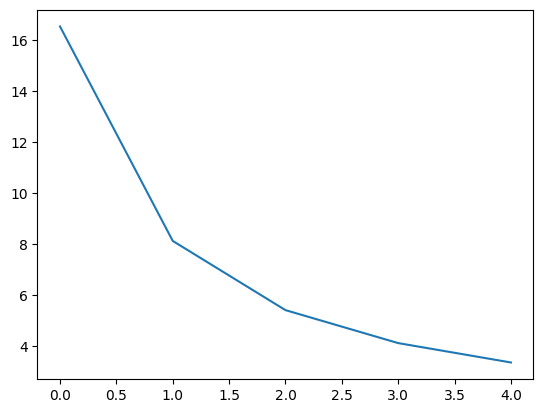

In [34]:
plt.plot(l)

In [21]:
# model = SimCLR()
model = MnistModel()

In [56]:
anchor_imgs = torch.stack([train_set[i][0] for i in range(len(train_set))])

In [61]:
h, _ = model(anchor_imgs)

In [62]:
h.size()

torch.Size([10000, 1024])

In [64]:
sim_matrix = torch.cdist(h, h)

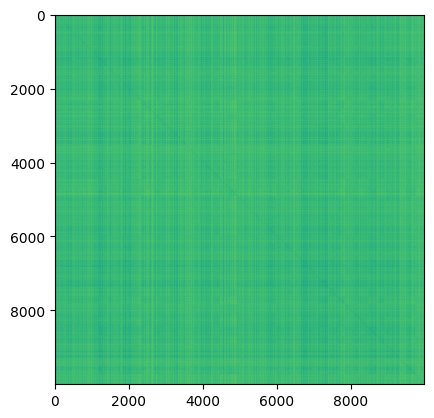

In [67]:
plt.imshow(sim_matrix.detach())

In [22]:
model = MnistModel()
train_set = TripletsMNIST(max_triplets=1000)
# train_set._generate_triplets()
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=8, shuffle=True, collate_fn=triplet_collate
    )

In [23]:
# train_set = TripletsMNIST()
# train_loader = triplet_train_loader(train_set, batch_size=2)
# model = MnistModel()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

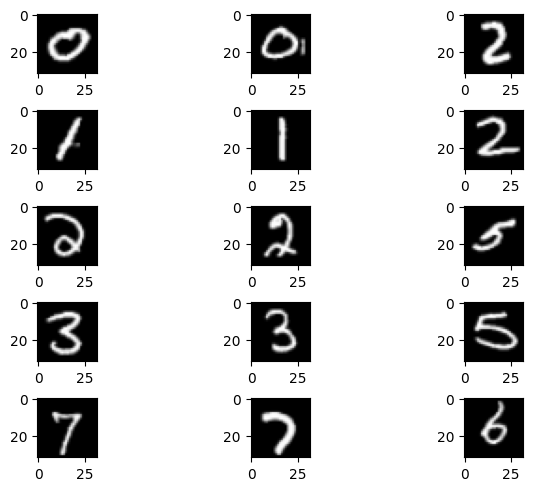

In [12]:
ne=5
fig, ax = plt.subplots(ne,3, constrained_layout=True)
for ep in range(ne):
    for i,(a,p,n) in enumerate(train_loader):
        None
        break
    
    ax[ep,0].imshow(a[0,:].permute(1, 2, 0))
    ax[ep,1].imshow(p[0,:].permute(1, 2, 0))
    ax[ep,2].imshow(n[0,:].permute(1, 2, 0))

In [24]:
num_epochs = 5
loss = -99 * np.ones((num_epochs))

for ep in range(num_epochs):
    loss_epoch = 0
    # print(f"running epoch {ep}")
    for i,(a,p,n) in enumerate(train_loader):
        # print(f"i: {i}, n: {n.shape}, a: {a.shape}")

        h_a, z_a = model(a)
        h_p, z_p = model(p)
        h_n, z_n = model(n)

        z_a = F.normalize(z_a, p=2, dim=1)
        z_p = F.normalize(z_p, p=2, dim=1)
        z_n = F.normalize(z_n, p=2, dim=1)

        optimizer.zero_grad()
        batch_loss = criterion(z_a, z_p, z_n)
        batch_loss.backward()
        loss_epoch += batch_loss.item()
        optimizer.step()

    loss[ep] = loss_epoch
    print(f"epoch: {ep}/{num_epochs}, loss : {loss_epoch}")


epoch: 0/5, loss : 53.85825724899769
epoch: 1/5, loss : 28.001952975988388
epoch: 2/5, loss : 20.590473368763924
epoch: 3/5, loss : 15.668628618121147
epoch: 4/5, loss : 11.704188294708729


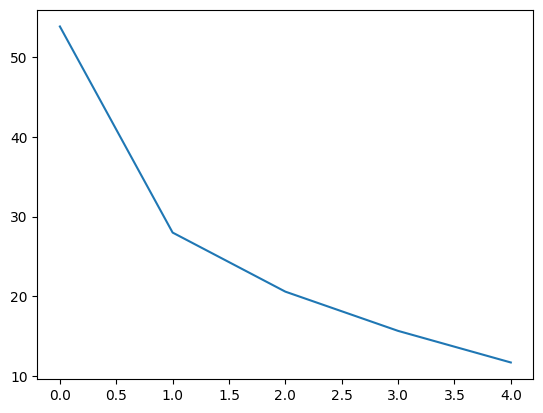

In [25]:
plt.plot(loss)

In [29]:
model = MnistModel()

train_set = TripletsMNIST(max_triplets=10000)
# train_set._generate_triplets()
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=32, shuffle=True, collate_fn=triplet_collate
    )

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [30]:
num_epochs = 30
loss64 = -99 * np.ones((num_epochs))

for ep in range(num_epochs):
    loss_epoch = 0
    # print(f"running epoch {ep}")
    for i,(a,p,n) in enumerate(train_loader):
        # print(f"i: {i}, n: {n.shape}, a: {a.shape}")

        h_a, z_a = model(a)
        h_p, z_p = model(p)
        h_n, z_n = model(n)

        z_a = F.normalize(z_a, p=2, dim=1)
        z_p = F.normalize(z_p, p=2, dim=1)
        z_n = F.normalize(z_n, p=2, dim=1)

        optimizer.zero_grad()
        batch_loss = criterion(z_a, z_p, z_n)
        batch_loss.backward()
        loss_epoch += batch_loss.item()
        optimizer.step()

    loss64[ep] = loss_epoch
    print(f"epoch: {ep}/{num_epochs}, loss : {loss_epoch}")


epoch: 0/30, loss : 65.87224059551954
epoch: 1/30, loss : 22.881858268752694
epoch: 2/30, loss : 16.772420305758715
epoch: 3/30, loss : 14.392506457865238
epoch: 4/30, loss : 10.577656680718064
epoch: 5/30, loss : 13.57439948245883
epoch: 6/30, loss : 8.894628195092082
epoch: 7/30, loss : 7.4845649022608995
epoch: 8/30, loss : 6.317569561302662
epoch: 9/30, loss : 6.016955154016614
epoch: 10/30, loss : 6.497045846655965
epoch: 11/30, loss : 4.551687214523554
epoch: 12/30, loss : 6.197377128526568
epoch: 13/30, loss : 3.9791464414447546
epoch: 14/30, loss : 3.7501590345054865
epoch: 15/30, loss : 3.1341771502047777
epoch: 16/30, loss : 3.013764088973403
epoch: 17/30, loss : 3.7844378016889095
epoch: 18/30, loss : 3.2868485432118177
epoch: 19/30, loss : 2.852025207132101
epoch: 20/30, loss : 1.9795661196112633
epoch: 21/30, loss : 1.8213829305022955
epoch: 22/30, loss : 1.5998065657913685
epoch: 23/30, loss : 1.5766639858484268
epoch: 24/30, loss : 2.041085544973612
epoch: 25/30, loss : 

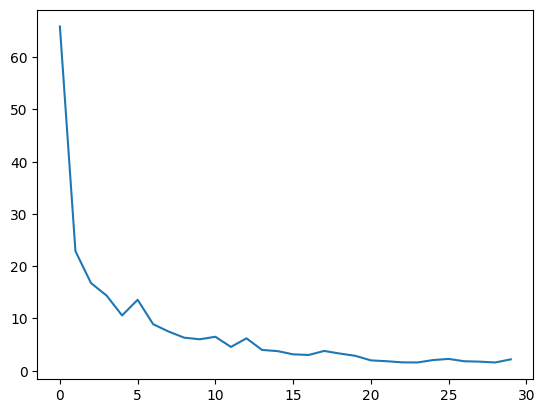

In [31]:
plt.plot(loss64)

In [17]:
train_loader.batch_size

64